# Исследование способов определения блюра на фото и сканах документов
- Автор: Кирилл Киселев
- Дата начала: 21.04.2022
- Описание исследования: исследование способов определения блюра на документах.

## 1. Имеющиеся изображения

Для тестирования способов определения блюра было выбрано 56 сканов и фото.

## 2. Загрузка библиотек

In [1]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import imutils

from sklearn.metrics import accuracy_score

## 3. Глобальные переменные

In [2]:
!pwd

/home/kirillk/PycharmProjects/useful_notebooks/ocr


In [3]:
FILE_PATH = '/home/kirillk/datasets/OCR/ocr_blur_detection/'
SCAN_PATH = '/home/kirillk/datasets/OCR/ocr_test_cases/test_cases/'

## 4. Исследование

### 1. Подготовка данных

In [7]:
# list of documents
doc_list = sorted(os.listdir(FILE_PATH))

In [8]:
df = pd.DataFrame({'doc_num':doc_list, 'true_blur':False})

In [9]:
blured_doc_list = [34, 38, 39, 40, 42, 44, 46, 47, 50, 53, 55]

In [10]:
for i in blured_doc_list:
    df['true_blur'][i] = True

/tmp/ipykernel_140422/1189065769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_blur'][i] = True


In [11]:
df.tail(10)

doc_num  true_blur
46  047.jpg       True
47  048.jpg       True
48  049.jpg      False
49  050.jpg      False
50  051.jpg       True
51  052.jpg      False
52  053.jpg      False
53  054.jpg       True
54  055.jpg      False
55  056.jpg       True

### 1. Быстрые преобразования Фурье

In [12]:
def detect_blur_fft(image, size=60, thresh=10, vis=False):
    # grab the dimensions of the image and use the dimensions to
    # derive the center (x, y)-coordinates
    (h, w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
        # compute the FFT to find the frequency transform, then shift
    # the zero frequency component (i.e., DC component located at
    # the top-left corner) to the center where it will be more
    # easy to analyze
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    
        # check to see if we are visualizing our output
    if vis:
        # compute the magnitude spectrum of the transform
        magnitude = 20 * np.log(np.abs(fftShift))
        # display the original input image
        (fig, ax) = plt.subplots(1, 2, )
        ax[0].imshow(image, cmap="gray")
        ax[0].set_title("Input")
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # display the magnitude image
        ax[1].imshow(magnitude, cmap="gray")
        ax[1].set_title("Magnitude Spectrum")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        # show our plots
        plt.show()
        
    # zero-out the center of the FFT shift (i.e., remove low
    # frequencies), apply the inverse shift such that the DC
    # component once again becomes the top-left, and then apply
    # the inverse FFT
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    
    # compute the magnitude spectrum of the reconstructed image,
    # then compute the mean of the magnitude values
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    # the image will be considered "blurry" if the mean value of the
    # magnitudes is less than the threshold value
    return (mean, mean <= thresh)

In [22]:
%%time
for treshhold in range(1, 30):
    predicted_blur = []
    for doc in doc_list:
#         print(f'-----{doc}----')
        # load the input image from disk, resize it, and convert it to
        # grayscale
        orig = cv2.imread(FILE_PATH + doc)
        orig = imutils.resize(orig, width=500)
        gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        # apply our blur detector using the FFT
        (mean, blurry) = detect_blur_fft(gray, size=60, thresh=treshhold, vis=False)
        # draw on the image, indicating whether or not it is blurry
        image = np.dstack([gray] * 3)
        color = (0, 0, 255) if blurry else (0, 255, 0)
        text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
        text = text.format(mean)
        cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color, 2)
        predicted_blur.append(blurry)
#         print("[INFO] {}".format(text))
    print(f'for threshhold {treshhold}: accuracy={accuracy_score(df.true_blur, predicted_blur)}')

for threshhold 1: accuracy=0.8035714285714286
for threshhold 2: accuracy=0.8035714285714286
for threshhold 3: accuracy=0.8035714285714286
for threshhold 4: accuracy=0.8214285714285714
for threshhold 5: accuracy=0.8214285714285714
for threshhold 6: accuracy=0.8392857142857143
for threshhold 7: accuracy=0.8571428571428571
for threshhold 8: accuracy=0.8571428571428571
for threshhold 9: accuracy=0.8571428571428571
for threshhold 10: accuracy=0.875
for threshhold 11: accuracy=0.875
for threshhold 12: accuracy=0.8928571428571429
for threshhold 13: accuracy=0.8928571428571429
for threshhold 14: accuracy=0.8928571428571429
for threshhold 15: accuracy=0.8928571428571429
for threshhold 16: accuracy=0.8928571428571429
for threshhold 17: accuracy=0.8928571428571429
for threshhold 18: accuracy=0.9285714285714286
for threshhold 19: accuracy=0.8928571428571429
for threshhold 20: accuracy=0.8928571428571429
for threshhold 21: accuracy=0.8928571428571429
for threshhold 22: accuracy=0.8928571428571429
f

In [38]:
%%time
for size in range(55, 65):
    predicted_blur = []
    for doc in doc_list:
#         print(f'-----{doc}----')
        # load the input image from disk, resize it, and convert it to
        # grayscale
        orig = cv2.imread(FILE_PATH + doc)
        orig = imutils.resize(orig, width=500)
        gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        # apply our blur detector using the FFT
        (mean, blurry) = detect_blur_fft(gray, size=size, thresh=18, vis=False)
        # draw on the image, indicating whether or not it is blurry
        image = np.dstack([gray] * 3)
        color = (0, 0, 255) if blurry else (0, 255, 0)
        text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
        text = text.format(mean)
        cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color, 2)
        predicted_blur.append(blurry)
#         print("[INFO] {}".format(text))
    print(f'for size {size}: accuracy={accuracy_score(df.true_blur, predicted_blur)}')

for size 55: accuracy=0.8928571428571429
for size 56: accuracy=0.8928571428571429
for size 57: accuracy=0.8928571428571429
for size 58: accuracy=0.8928571428571429
for size 59: accuracy=0.875
for size 60: accuracy=0.9285714285714286
for size 61: accuracy=0.9464285714285714
for size 62: accuracy=0.9285714285714286
for size 63: accuracy=0.9285714285714286
for size 64: accuracy=0.9285714285714286
CPU times: user 1min 57s, sys: 1min 2s, total: 2min 59s
Wall time: 2min 25s


Получены оптимальные знаяения size=61, thresh=18

In [33]:
predicted_blur = []

In [34]:
for doc in doc_list: 
    orig = cv2.imread(FILE_PATH + doc)
    orig = imutils.resize(orig, width=500)
    gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    # apply our blur detector using the FFT
    (mean, blurry) = detect_blur_fft(gray, size=61, thresh=18, vis=False)
    # draw on the image, indicating whether or not it is blurry
    image = np.dstack([gray] * 3)
    color = (0, 0, 255) if blurry else (0, 255, 0)
    text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
    text = text.format(mean)
    cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color, 2)
    predicted_blur.append(blurry)
    # print("[INFO] {}".format(text))
#     print(f'for threshhold {treshhold}: accuracy={accuracy_score(df.true_blur, predicted_blur)}')

In [39]:
df['predicted_fourier_blur'] = predicted_blur

In [40]:
df[df['true_blur'] != df['predicted_fourier_blur']]

doc_num  true_blur  predicted_blur  predicted_fourier_blur
30  031.jpg      False           False                    True
31  032.jpg      False            True                    True
38  039.jpg       True           False                   False
44  045.jpg       True           False                   False

### 2. Преобразования Лапласа

In [ ]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()
# construct the argument parse and parse the arguments


In [46]:
# look at images
for doc in doc_list: 
    # load the image, convert it to grayscale, and compute the
    # focus measure of the image using the Variance of Laplacian
    # method
    image = cv2.imread(FILE_PATH + doc)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    text = "Not Blurry"
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < 10:
        text = "Blurry"
    # show the image
    cv2.putText(image, "{}: {:.2f}".format(text, fm), (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    cv2.imshow("Image", image)
    cv2.imshow("Output", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [71]:
%%time
for thresh in range(50, 100):
    predicted_laplassian_blur = []
    for doc in doc_list: 
        # load the image, convert it to grayscale, and compute the
        # focus measure of the image using the Variance of Laplacian
        # method
        image = cv2.imread(FILE_PATH + doc)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fm = cv2.Laplacian(gray, cv2.CV_64F).var()
        blurry = False
        # if the focus measure is less than the supplied threshold,
        # then the image should be considered "blurry"
        if fm < thresh:
            blurry = True
        predicted_laplassian_blur.append(blurry)
    laplassian_accuracy = accuracy_score(df['true_blur'], predicted_laplassian_blur)
    print(f'for thresh={thresh} accuracy score={laplassian_accuracy}')

KeyboardInterrupt: 

In [73]:
%%time
for thresh in range(50, 100):
    for size in np.arange(.1, 1, .1):
        predicted_laplassian_blur = []
        for doc in doc_list: 
            # load the image, convert it to grayscale, and compute the
            # focus measure of the image using the Variance of Laplacian
            # method
            image = cv2.imread(FILE_PATH + doc)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (0, 0), fx=size, fy=size)
            fm = cv2.Laplacian(gray, cv2.CV_64F).var()
            blurry = False
            # if the focus measure is less than the supplied threshold,
            # then the image should be considered "blurry"
            if fm < thresh:
                blurry = True
            predicted_laplassian_blur.append(blurry)
        laplassian_accuracy = accuracy_score(df['true_blur'], predicted_laplassian_blur)
        print(f'for thresh={thresh}, size={size} - accuracy score={laplassian_accuracy}')

for thresh=50, size=0.1 - accuracy score=0.8035714285714286
for thresh=50, size=0.2 - accuracy score=0.8035714285714286
for thresh=50, size=0.30000000000000004 - accuracy score=0.8035714285714286
for thresh=50, size=0.4 - accuracy score=0.9285714285714286
for thresh=50, size=0.5 - accuracy score=0.9464285714285714
for thresh=50, size=0.6 - accuracy score=1.0
for thresh=50, size=0.7000000000000001 - accuracy score=1.0
for thresh=50, size=0.8 - accuracy score=1.0
for thresh=50, size=0.9 - accuracy score=1.0
for thresh=51, size=0.1 - accuracy score=0.8035714285714286
for thresh=51, size=0.2 - accuracy score=0.8035714285714286
for thresh=51, size=0.30000000000000004 - accuracy score=0.8035714285714286
for thresh=51, size=0.4 - accuracy score=0.9285714285714286
for thresh=51, size=0.5 - accuracy score=0.9464285714285714
for thresh=51, size=0.6 - accuracy score=1.0
for thresh=51, size=0.7000000000000001 - accuracy score=1.0
for thresh=51, size=0.8 - accuracy score=1.0
for thresh=51, size=0.9

for thresh=66, size=0.2 - accuracy score=0.8035714285714286
for thresh=66, size=0.30000000000000004 - accuracy score=0.8392857142857143
for thresh=66, size=0.4 - accuracy score=0.9285714285714286
for thresh=66, size=0.5 - accuracy score=0.9821428571428571
for thresh=66, size=0.6 - accuracy score=1.0
for thresh=66, size=0.7000000000000001 - accuracy score=1.0
for thresh=66, size=0.8 - accuracy score=1.0
for thresh=66, size=0.9 - accuracy score=1.0
for thresh=67, size=0.1 - accuracy score=0.8035714285714286
for thresh=67, size=0.2 - accuracy score=0.8035714285714286
for thresh=67, size=0.30000000000000004 - accuracy score=0.8392857142857143
for thresh=67, size=0.4 - accuracy score=0.9285714285714286
for thresh=67, size=0.5 - accuracy score=0.9821428571428571
for thresh=67, size=0.6 - accuracy score=1.0
for thresh=67, size=0.7000000000000001 - accuracy score=1.0
for thresh=67, size=0.8 - accuracy score=1.0
for thresh=67, size=0.9 - accuracy score=1.0
for thresh=68, size=0.1 - accuracy sco

for thresh=82, size=0.30000000000000004 - accuracy score=0.8571428571428571
for thresh=82, size=0.4 - accuracy score=0.9285714285714286
for thresh=82, size=0.5 - accuracy score=1.0
for thresh=82, size=0.6 - accuracy score=1.0
for thresh=82, size=0.7000000000000001 - accuracy score=1.0
for thresh=82, size=0.8 - accuracy score=1.0
for thresh=82, size=0.9 - accuracy score=1.0
for thresh=83, size=0.1 - accuracy score=0.8035714285714286
for thresh=83, size=0.2 - accuracy score=0.8035714285714286
for thresh=83, size=0.30000000000000004 - accuracy score=0.8571428571428571
for thresh=83, size=0.4 - accuracy score=0.9285714285714286
for thresh=83, size=0.5 - accuracy score=1.0
for thresh=83, size=0.6 - accuracy score=1.0
for thresh=83, size=0.7000000000000001 - accuracy score=1.0
for thresh=83, size=0.8 - accuracy score=1.0
for thresh=83, size=0.9 - accuracy score=1.0
for thresh=84, size=0.1 - accuracy score=0.8035714285714286
for thresh=84, size=0.2 - accuracy score=0.8035714285714286
for thre

for thresh=98, size=0.9 - accuracy score=0.9821428571428571
for thresh=99, size=0.1 - accuracy score=0.8035714285714286
for thresh=99, size=0.2 - accuracy score=0.8035714285714286
for thresh=99, size=0.30000000000000004 - accuracy score=0.8928571428571429
for thresh=99, size=0.4 - accuracy score=0.9285714285714286
for thresh=99, size=0.5 - accuracy score=1.0
for thresh=99, size=0.6 - accuracy score=1.0
for thresh=99, size=0.7000000000000001 - accuracy score=1.0
for thresh=99, size=0.8 - accuracy score=1.0
for thresh=99, size=0.9 - accuracy score=0.9821428571428571
CPU times: user 1h 48min 55s, sys: 2h 21min 37s, total: 4h 10min 32s
Wall time: 3h 56min 23s


In [69]:
%%time
for size in np.arange(.1, 1, .1):
    predicted_laplassian_blur = []
    for doc in doc_list: 
        # load the image, convert it to grayscale, and compute the
        # focus measure of the image using the Variance of Laplacian
        # method
        image = cv2.imread(FILE_PATH + doc)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (0, 0), fx=size, fy=size)
        fm = cv2.Laplacian(gray, cv2.CV_64F).var()
        blurry = False
        # if the focus measure is less than the supplied threshold,
        # then the image should be considered "blurry"
        if fm < thresh:
            blurry = True
        predicted_laplassian_blur.append(blurry)
    laplassian_accuracy = accuracy_score(df['true_blur'], predicted_laplassian_blur)
    print(f'for size={size}, accuracy score={laplassian_accuracy}')

for thresh=0.1, accuracy score=0.8035714285714286
for thresh=0.2, accuracy score=0.8035714285714286
for thresh=0.30000000000000004, accuracy score=0.8035714285714286
for thresh=0.4, accuracy score=0.9285714285714286
for thresh=0.5, accuracy score=0.9464285714285714
for thresh=0.6, accuracy score=1.0
for thresh=0.7000000000000001, accuracy score=1.0
for thresh=0.8, accuracy score=1.0
for thresh=0.9, accuracy score=1.0
CPU times: user 1min 40s, sys: 55.7 s, total: 2min 35s
Wall time: 2min 18s


In [70]:
thresh

51

In [57]:
predicted_laplassian_blur = []

In [79]:
%%time
predicted_laplassian_blur = []

for doc in doc_list: 
    # load the image, convert it to grayscale, and compute the
    # focus measure of the image using the Variance of Laplacian
    # method
    image = cv2.imread(FILE_PATH + doc)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (0, 0), fx=0.5, fy=0.5)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    blurry = False
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < 88:
        blurry = True
    predicted_laplassian_blur.append(blurry)
#     print(predicted_laplassian_blur)
laplassian_accuracy = accuracy_score(df['true_blur'], predicted_laplassian_blur)
print(f'accuracy score={laplassian_accuracy}')

accuracy score=1.0
CPU times: user 8.87 s, sys: 3.17 s, total: 12 s
Wall time: 9.96 s


In [92]:
doc_list[49]

'050.jpg'

In [4]:
%%time
image = cv2.imread('/home/kirillk/datasets/OCR/ocr_test_cases/test_cases/174.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (0, 0), fx=0.5, fy=0.5)
fm = cv2.Laplacian(gray, cv2.CV_64F).var()
blurry = False
# if the focus measure is less than the supplied threshold,
# then the image should be considered "blurry"
if fm < 88:
    blurry = True
print(fm, blurry)

62.32637562537747 True
CPU times: user 189 ms, sys: 164 ms, total: 353 ms
Wall time: 209 ms


In [6]:
%%time
for i in ['112.jpg', '115.jpg', '155.jpg', '157.jpg', '159.jpg', 
          '166.jpg', '168.jpg', '170.jpg', '174.jpg', '195.jpg']:
    image = cv2.imread('/home/kirillk/PycharmProjects/ocr-prototype/assets/dataset/' + i)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (0, 0), fx=0.5, fy=0.5)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    blurry = False
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < 88:
        blurry = True
    print(i, fm, blurry)

112.jpg 27.405689470724287 True
115.jpg 20.32061273776698 True
155.jpg 79.34626734123503 True
157.jpg 19.981239313220122 True
159.jpg 17.1168977393696 True
166.jpg 13.307134727226895 True
168.jpg 49.57847682024173 True
170.jpg 13.806740421831064 True
174.jpg 62.32637562537747 True
195.jpg 22.607674577820557 True
CPU times: user 2.07 s, sys: 650 ms, total: 2.72 s
Wall time: 1.88 s


In [10]:
blurry_list = ['112.jpg', '115.jpg', '155.jpg', '157.jpg', '159.jpg', '166.jpg', '168.jpg', '170.jpg', '174.jpg', '195.jpg']

In [11]:
not_blur_list =[i for i in os.listdir('/home/kirillk/PycharmProjects/ocr-prototype/assets/dataset/') if i not in blurry_list]
not_blur_list

['108.jpg',
 '134.jpg',
 '145.jpg',
 '020.jpg',
 '172.jpg',
 '030.jpg',
 '044.jpg',
 '072.jpg',
 '183.jpg',
 '088.jpg',
 '192.jpg',
 '191.jpg',
 '122.jpg',
 '029.jpg',
 '144.jpg',
 '109.jpg',
 '049.jpg',
 '037.jpg',
 '138.jpg',
 '200.jpg',
 '189.jpg',
 '114.jpg',
 '093.jpg',
 '010.jpg',
 '148.jpg',
 '133.jpg',
 '199.jpg',
 '124.jpg',
 '032.jpg',
 '152.jpg',
 '171.jpg',
 '177.jpg',
 '075.jpg',
 '038.jpg',
 '000.jpg',
 '173.jpg',
 '126.jpg',
 '035.jpg',
 '003.jpg',
 '062.jpg',
 '094.jpg',
 '184.jpg',
 '004.jpg',
 '083.jpg',
 '164.jpg',
 '025.jpg',
 '101.jpg',
 '028.jpg',
 '076.jpg',
 '146.jpg',
 '067.jpg',
 '052.jpg',
 '087.jpg',
 '018.jpg',
 '051.jpg',
 '147.jpg',
 '187.jpg',
 '047.jpg',
 '140.jpg',
 '079.jpg',
 '061.jpg',
 '096.jpg',
 '007.jpg',
 '011.jpg',
 '023.jpg',
 '120.jpg',
 '084.jpg',
 '065.jpg',
 '098.jpg',
 '130.jpg',
 '175.jpg',
 '022.jpg',
 '009.jpg',
 '069.jpg',
 '014.jpg',
 '054.jpg',
 '019.jpg',
 '056.jpg',
 '008.jpg',
 '017.jpg',
 '131.jpg',
 '137.jpg',
 '198.jpg',
 '03

In [14]:
len(not_blur_list)

193

In [15]:
fm_list = []

for i in not_blur_list:
    image = cv2.imread('/home/kirillk/PycharmProjects/ocr-prototype/assets/dataset/' + i)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (0, 0), fx=0.5, fy=0.5)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    blurry = False
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < 88:
        blurry = True
    print(i, fm, blurry)
    fm_list.append(fm)

108.jpg 898.1757688403278 False
134.jpg 2293.090630482721 False
145.jpg 2297.3055067706982 False
020.jpg 1126.7997128304619 False
172.jpg 2128.4884183364725 False
030.jpg 2097.524033515161 False
044.jpg 4271.559433515227 False
072.jpg 1265.7271409005887 False
183.jpg 2349.687846216281 False
088.jpg 2149.1537438321366 False
192.jpg 2106.5010633783663 False
191.jpg 1503.8987789221776 False
122.jpg 2450.5907334056756 False
029.jpg 2115.4853131921823 False
144.jpg 1481.9493670173779 False
109.jpg 3772.981880161536 False
049.jpg 3155.154001787687 False
037.jpg 2153.281607556839 False
138.jpg 3383.285754174842 False
200.jpg 1536.6790566433224 False
189.jpg 2721.2537935843 False
114.jpg 745.3717106885803 False
093.jpg 3288.1486092420355 False
010.jpg 2019.0849114552962 False
148.jpg 2344.8310924150132 False
133.jpg 2499.0652192030093 False
199.jpg 1920.933576535581 False
124.jpg 2931.672174249242 False
032.jpg 2123.5971299588364 False
152.jpg 2359.834802957162 False
171.jpg 2336.26188705874 F

In [17]:
min(fm_list)

582.2407248284678

In [102]:
scan_list = [x for x in os.listdir('/home/kirillk/datasets/OCR/ocr_test_cases/test_cases/') if x.endswith('.jpg')]

In [105]:
len(scan_list)

203

In [110]:
blurry_list = {}

for i in scan_list:
    image = cv2.imread(SCAN_PATH + i)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (0, 0), fx=.5, fy=.5)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    blurry = False
    if fm < 88:
#         blurry = True
        blurry_list[i] = [fm, True]
    
blurry_list

{'195.jpg': [22.607674577820557, True],
 '155.jpg': [79.34626734123503, True],
 '115.jpg': [20.32061273776698, True],
 '168.jpg': [49.57847682024173, True],
 '112.jpg': [27.405689470724287, True],
 '159.jpg': [17.1168977393696, True],
 '166.jpg': [13.307134727226895, True],
 '170.jpg': [13.806740421831064, True],
 '157.jpg': [19.981239313220122, True],
 '174.jpg': [62.32637562537747, True]}

In [96]:
%%time
image = cv2.imread(FILE_PATH + doc_list[49])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (0, 0), fx=0.5, fy=0.5)
fm = cv2.Laplacian(gray, cv2.CV_64F).var()
blurry = False
# if the focus measure is less than the supplied threshold,
# then the image should be considered "blurry"
if fm < 88:
    blurry = True
blurry

CPU times: user 223 ms, sys: 132 ms, total: 355 ms
Wall time: 291 ms


False

In [91]:
# look at images
for doc in doc_list: 
    # load the image, convert it to grayscale, and compute the
    # focus measure of the image using the Variance of Laplacian
    # method
    image = cv2.imread(FILE_PATH + doc)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (0, 0), fx=0.5, fy=0.5)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    text = "Not Blurry"
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < 88:
        text = "Blurry"
    # show the image
    image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
    cv2.putText(image, "{}: {:.2f}".format(text, fm), (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    cv2.imshow("Output", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
image = cv2.imread(FILE_PATH + doc_list[1])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (0, 0), fx=0.5, fy=0.5)
fm = cv2.Laplacian(gray, cv2.CV_64F).var()
blurry = False
# if the focus measure is less than the supplied threshold,
# then the image should be considered "blurry"
if fm < 88:
    text = "Blurry"
    # show the image
image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
cv2.putText(image, "{}: {:.2f}".format(text, fm), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
cv2.imshow("Output", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

/tmp/ipykernel_103425/3755373449.py:10: RuntimeWarning: divide by zero encountered in log
  magnitude = 20 * np.log(np.abs(fftShift))
/tmp/ipykernel_103425/3755373449.py:14: RuntimeWarning: divide by zero encountered in log
  magnitude = 20 * np.log(np.abs(fftShift))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1077, 1483)
(688, 500, 3)
(688, 500, 3)


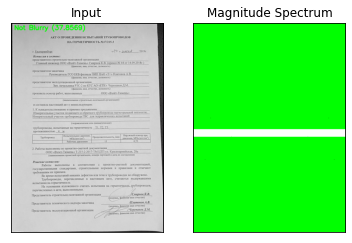

NameError: name 'size' is not defined

In [32]:
test_image = cv2.imread(FILE_PATH + doc_list[0])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
(h, w) = test_image.shape
(cX, cY) = (int(w / 2), int(h / 2))
print((cX, cY))
fft = np.fft.fft2(image)
print(fft.shape)
fftShift = np.fft.fftshift(fft)
print(fftShift.shape)
magnitude = 20 * np.log(np.abs(fftShift))
magnitude.shape

# compute the magnitude spectrum of the transform
magnitude = 20 * np.log(np.abs(fftShift))
# display the original input image
(fig, ax) = plt.subplots(1, 2, )
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Input")
ax[0].set_xticks([])
ax[0].set_yticks([])
# display the magnitude image
ax[1].imshow(magnitude, cmap="gray")
ax[1].set_title("Magnitude Spectrum")
ax[1].set_xticks([])
ax[1].set_yticks([])
# show our plots
plt.show()

fftShift[cY - size:cY + size, cX - size:cX + size] = 0
fftShift = np.fft.ifftshift(fftShift)
recon = np.fft.ifft2(fftShift)

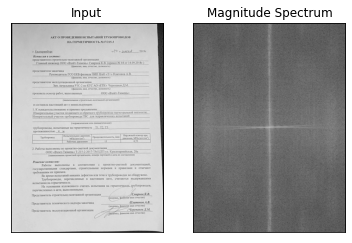

[INFO] Blurry (37.8569)


In [48]:
# load the input image from disk, resize it, and convert it to
# grayscale
orig = cv2.imread(FILE_PATH + doc_list[0])
orig = imutils.resize(orig, width=500)
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
# apply our blur detector using the FFT
(mean, blurry) = detect_blur_fft(gray, size=60, thresh=100, vis=True)
# draw on the image, indicating whether or not it is blurry
image = np.dstack([gray] * 3)
color = (0, 0, 255) if blurry else (0, 255, 0)
text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
text = text.format(mean)
cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color, 2)
print("[INFO] {}".format(text))
# show the output image
# cv2.imshow("Output", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

-----001.jpg----


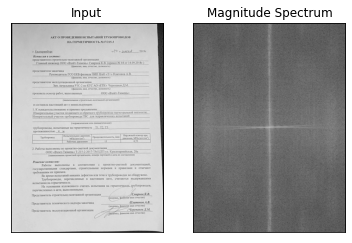

[INFO] Blurry (37.8569)
-----002.JPG----


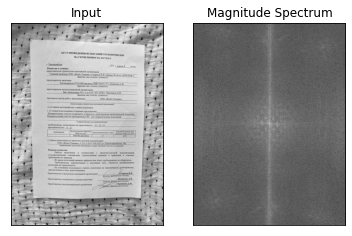

[INFO] Blurry (40.1816)
-----003.JPG----


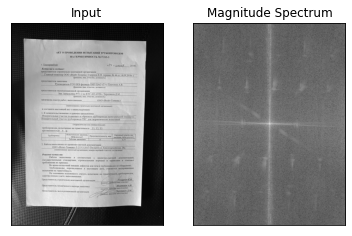

[INFO] Blurry (35.4090)
-----004.JPG----


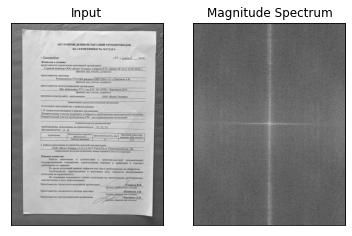

[INFO] Blurry (35.5650)
-----005.JPG----


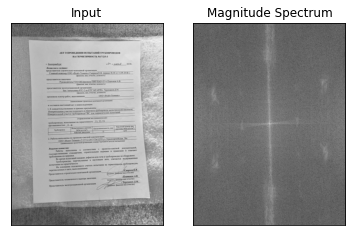

[INFO] Blurry (38.2006)
-----006.JPG----


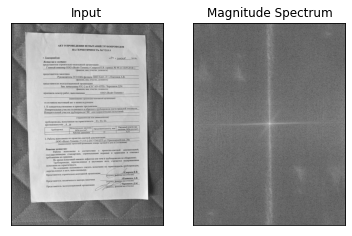

[INFO] Blurry (39.5584)
-----007.JPG----


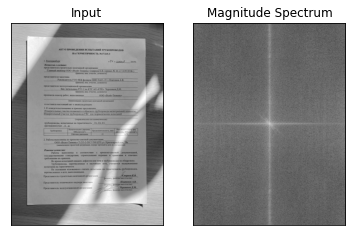

[INFO] Blurry (31.7459)
-----008.JPG----


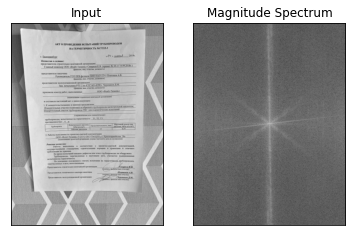

[INFO] Blurry (36.5395)
-----009.JPG----


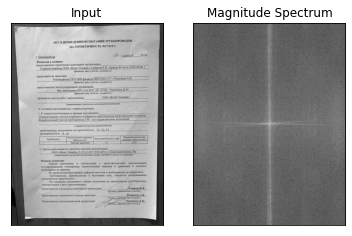

[INFO] Blurry (38.4886)
-----010.JPG----


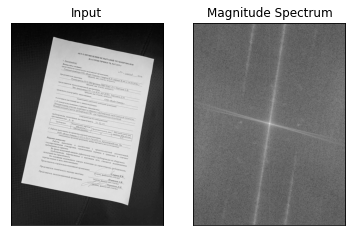

[INFO] Blurry (27.4743)
-----011.JPG----


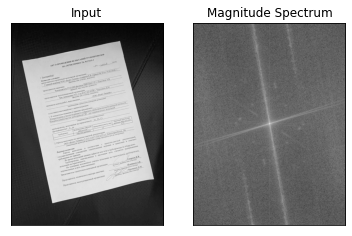

[INFO] Blurry (27.1417)
-----012.JPG----


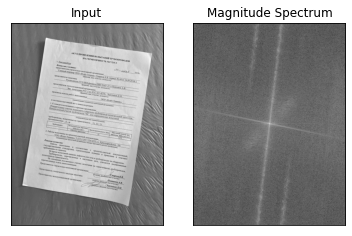

[INFO] Blurry (29.9780)
-----013.JPG----


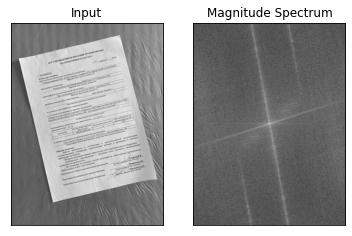

[INFO] Blurry (28.4851)
-----014.jpg----


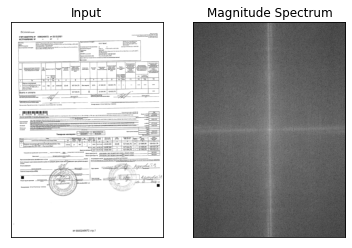

[INFO] Blurry (34.4283)
-----015.jpg----


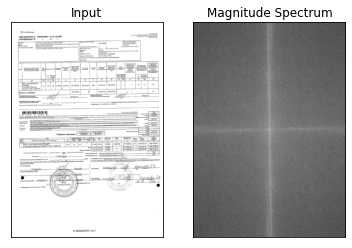

[INFO] Blurry (34.7976)
-----016.jpg----


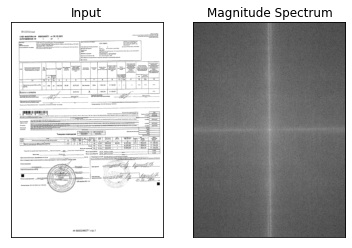

[INFO] Blurry (33.3156)
-----017.jpg----


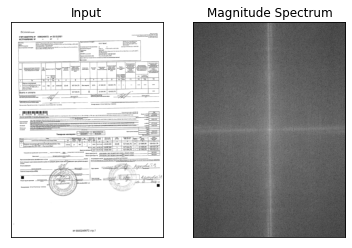

[INFO] Blurry (34.4283)
-----018.jpg----


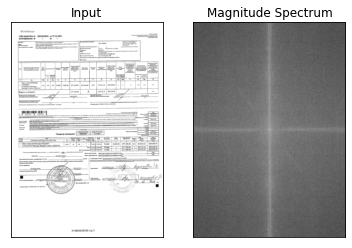

[INFO] Blurry (34.2952)
-----019.jpg----


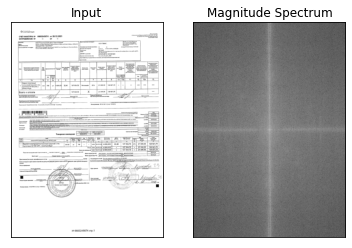

[INFO] Blurry (34.5327)
-----020.jpg----


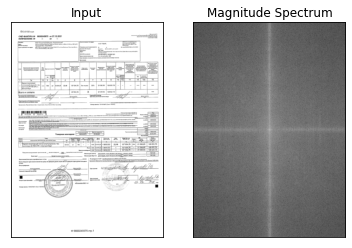

[INFO] Blurry (34.2434)
-----021.jpg----


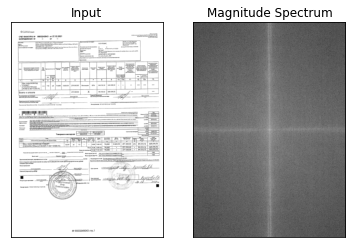

[INFO] Blurry (34.5043)
-----022.jpg----


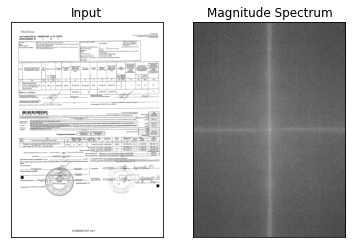

[INFO] Blurry (34.6301)
-----023.jpg----


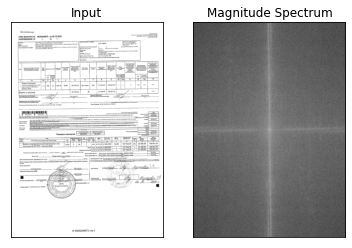

[INFO] Blurry (34.8111)
-----024.jpg----


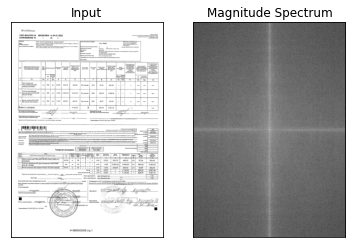

[INFO] Blurry (39.4934)
-----025.jpg----


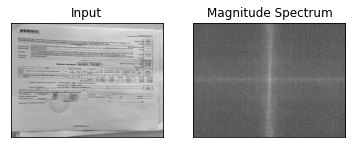

[INFO] Blurry (30.4383)
-----026.jpg----


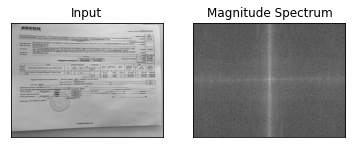

[INFO] Blurry (30.1671)
-----027.jpg----


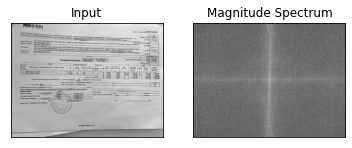

[INFO] Blurry (33.2099)
-----028.jpg----


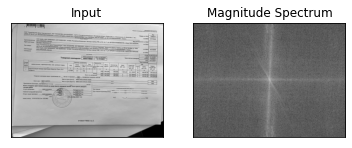

[INFO] Blurry (32.0657)
-----029.jpg----


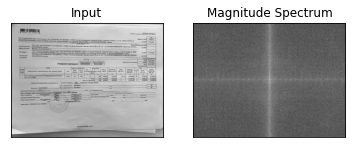

[INFO] Blurry (31.9701)
-----030.jpg----


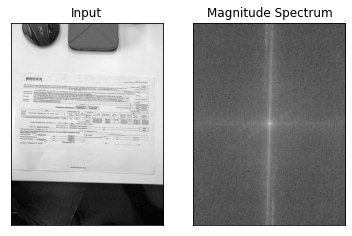

[INFO] Blurry (23.8104)
-----031.jpg----


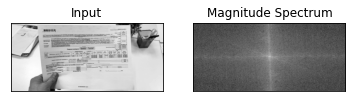

[INFO] Blurry (18.8953)
-----032.jpg----


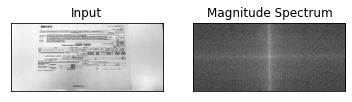

[INFO] Blurry (11.4277)
-----033.jpg----


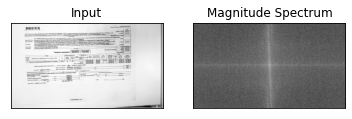

[INFO] Blurry (22.9184)
-----034.jpg----


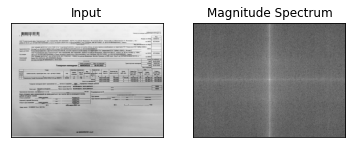

[INFO] Blurry (29.1461)
-----035.jpg----


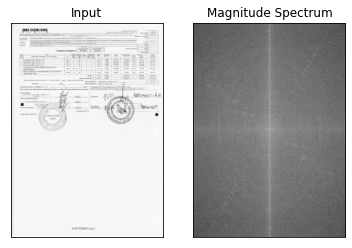

[INFO] Blurry (3.8286)
-----036.jpg----


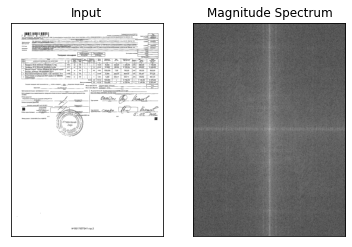

[INFO] Blurry (17.6674)
-----037.jpg----


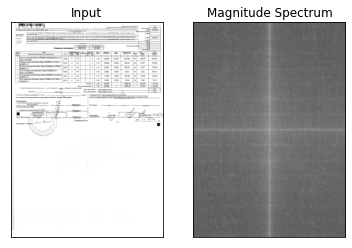

[INFO] Blurry (18.5553)
-----038.jpg----


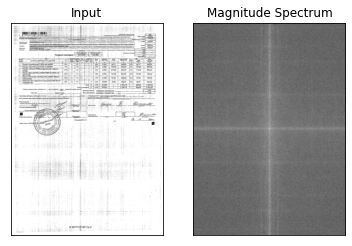

[INFO] Blurry (36.5400)
-----039.jpg----


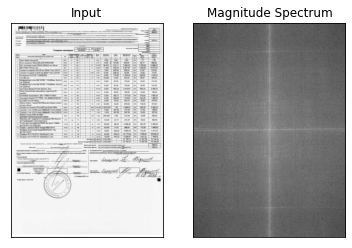

[INFO] Blurry (34.9547)
-----040.jpg----


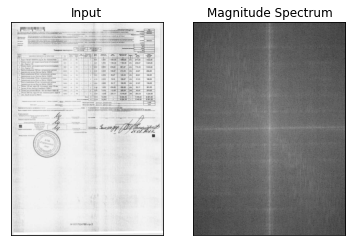

[INFO] Blurry (17.8050)
-----041.jpg----


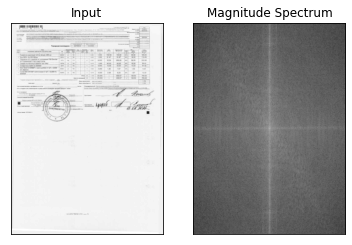

[INFO] Blurry (5.2287)
-----042.jpg----


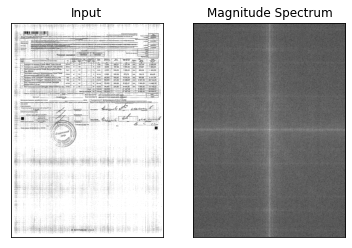

[INFO] Blurry (43.5274)
-----043.jpg----


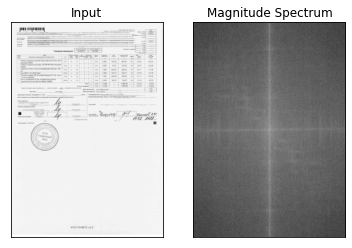

[INFO] Blurry (6.3998)
-----044.jpg----


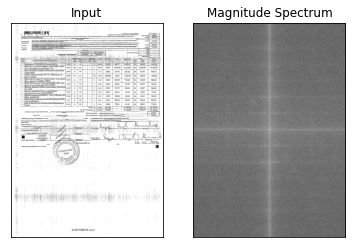

[INFO] Blurry (36.4337)
-----045.jpg----


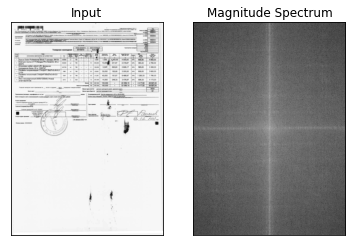

[INFO] Blurry (20.3640)
-----046.jpg----


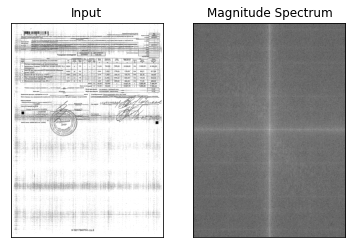

[INFO] Blurry (40.9411)
-----047.jpg----


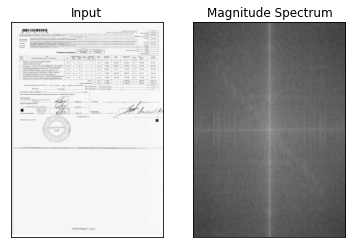

[INFO] Blurry (9.5875)
-----048.jpg----


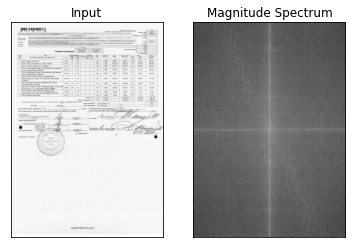

[INFO] Blurry (17.7032)
-----049.jpg----


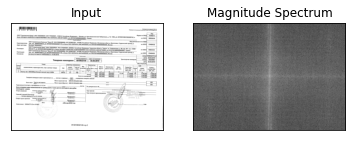

[INFO] Blurry (32.1522)
-----050.jpg----


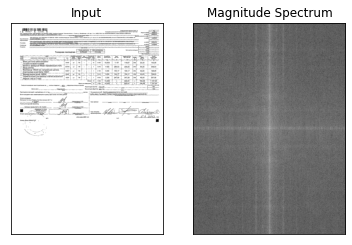

[INFO] Blurry (20.7026)
-----051.jpg----


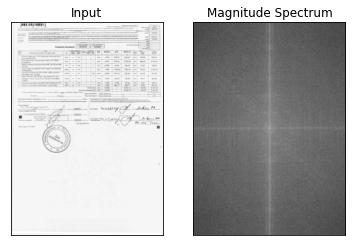

[INFO] Blurry (11.8288)
-----052.jpg----


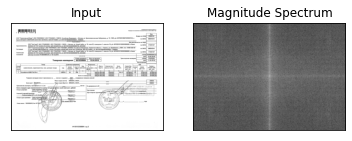

[INFO] Blurry (32.0448)
-----053.jpg----


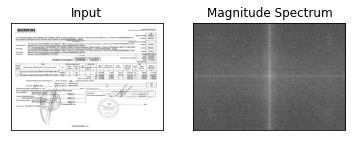

[INFO] Blurry (34.5122)
-----054.jpg----


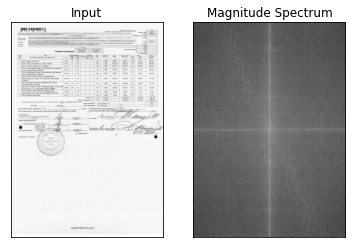

[INFO] Blurry (17.7032)
-----055.jpg----


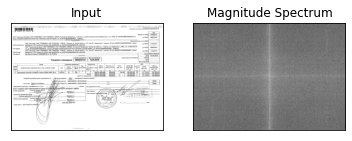

[INFO] Blurry (34.9358)
-----056.jpg----


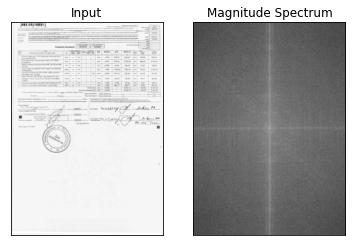

[INFO] Blurry (11.8288)


In [50]:
for doc in doc_list:
    print(f'-----{doc}----')
    # load the input image from disk, resize it, and convert it to
    # grayscale
    orig = cv2.imread(FILE_PATH + doc)
    orig = imutils.resize(orig, width=500)
    gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    # apply our blur detector using the FFT
    (mean, blurry) = detect_blur_fft(gray, size=60, thresh=100, vis=True)
    # draw on the image, indicating whether or not it is blurry
    image = np.dstack([gray] * 3)
    color = (0, 0, 255) if blurry else (0, 255, 0)
    text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
    text = text.format(mean)
    cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color, 2)
    print("[INFO] {}".format(text))
    # show the output image
    # cv2.imshow("Output", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()